Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.6.1

torch 1.2.0


- Runs on CPU or GPU (if available)

# Most Basic Graph Neural Network with Gaussian Filter on MNIST

Implementing a very basic graph neural network (GNN) using a Gaussian filter. 

Here, the 28x28 image of a digit in MNIST represents the graph, where each pixel (i.e., cell in the grid) represents a particular node. The feature of that node is simply the pixel intensity in range [0, 1]. 

Here, the adjacency matrix of the pixels is basically just determined by their neighborhood pixels. Using a Gaussian filter, we connect pixels based on their Euclidean distance in the grid.

Using this adjacency matrix $A$, we can compute the output of a layer as 

$$X^{(l+1)}=A X^{(l)} W^{(l)}.$$

Here, $A$ is the $N \times N$ adjacency matrix, and $X$ is the $N \times C$ feature matrix (a  2D coordinate array, where $N$ is the total number of pixels -- $28 \times 28 = 784$ in MNIST). $W$ is the weight matrix of shape $N \times P$, where $P$ would represent the number of classes if we have only a single hidden layer.



- Inspired by and based on Boris Knyazev's tutorial at https://medium.com/@BorisAKnyazev/tutorial-on-graph-neural-networks-for-computer-vision-and-beyond-part-1-3d9fada3b80d.

## Imports

In [2]:
import time
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 20
BATCH_SIZE = 128
IMG_SIZE = 28

# Architecture
NUM_CLASSES = 10

## MNIST Dataset

In [5]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

custom_transform = transforms.Compose([transforms.ToTensor()])


train_and_valid = datasets.MNIST(root='data', 
                                 train=True, 
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform,
                              download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [6]:
def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    
    # N = img_size^2
    # construct 2D coordinate array (shape N x 2) and normalize
    # in range [0, 1]
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size

    # compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')
    
    # Apply Gaussian filter
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()

    # Normalization as per (Kipf & Welling, ICLR 2017)
    D = A.sum(1)  # nodes degree (N,)
    D_hat = (D + 1e-5) ** (-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N
    
    return A_hat

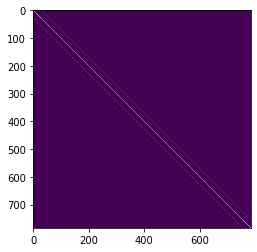

In [7]:
plt.imshow(precompute_adjacency_matrix(28));

In [8]:
##########################
### MODEL
##########################

        

class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)
        self.register_buffer('A', A)

        

    def forward(self, x):
        
        B = x.size(0) # Batch size

        ### Reshape Adjacency Matrix
        # [N, N] Adj. matrix -> [1, N, N] Adj tensor where N = HxW
        A_tensor = self.A.unsqueeze(0)
        # [1, N, N] Adj tensor -> [B, N, N] tensor
        A_tensor = self.A.expand(B, -1, -1)
        
        ### Reshape inputs
        # [B, C, H, W] => [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)
        
        # bmm = batch matrix product to sum the neighbor features
        # Input: [B, N, N] x [B, N, 1]
        # Output: [B, N]
        avg_neighbor_features = (torch.bmm(A_tensor, x_reshape).view(B, -1))
        
        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [9]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

## Training

In [10]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/461 | Cost: 2.2677
Epoch: 001/020 | Batch 150/461 | Cost: 0.8999
Epoch: 001/020 | Batch 300/461 | Cost: 0.6701
Epoch: 001/020 | Batch 450/461 | Cost: 0.4905
Epoch: 001/020
Train ACC: 87.02 | Validation ACC: 92.40
Time elapsed: 0.08 min
Epoch: 002/020 | Batch 000/461 | Cost: 0.5868
Epoch: 002/020 | Batch 150/461 | Cost: 0.4526
Epoch: 002/020 | Batch 300/461 | Cost: 0.4192
Epoch: 002/020 | Batch 450/461 | Cost: 0.3647
Epoch: 002/020
Train ACC: 88.25 | Validation ACC: 92.60
Time elapsed: 0.14 min
Epoch: 003/020 | Batch 000/461 | Cost: 0.4316
Epoch: 003/020 | Batch 150/461 | Cost: 0.4165
Epoch: 003/020 | Batch 300/461 | Cost: 0.4130
Epoch: 003/020 | Batch 450/461 | Cost: 0.3991
Epoch: 003/020
Train ACC: 88.80 | Validation ACC: 93.30
Time elapsed: 0.22 min
Epoch: 004/020 | Batch 000/461 | Cost: 0.3537
Epoch: 004/020 | Batch 150/461 | Cost: 0.3460
Epoch: 004/020 | Batch 300/461 | Cost: 0.4011
Epoch: 004/020 | Batch 450/461 | Cost: 0.4666
Epoch: 004/020
Train ACC: 8

## Evaluation

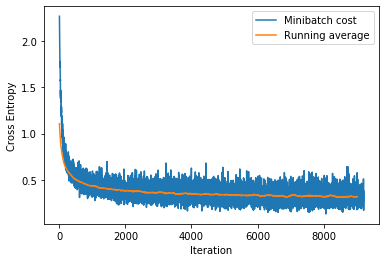

In [11]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

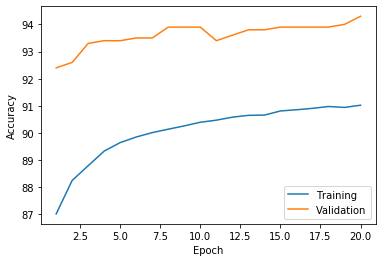

In [12]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 94.30%
Test ACC: 91.63%


In [14]:
%watermark -iv

torchvision 0.4.0a0+6b959ee
torch       1.2.0
numpy       1.16.4
matplotlib  3.1.0

